In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')

In [2]:
%matplotlib inline

In [3]:
# Stopping tolerance [cm]
stop_tol = 0.01
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09


In [4]:
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [5]:
# Vertical axis
dz = 1; # [cm]
zmin = 0; # [cm]
zmax = 100; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

In [6]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0;
DeltaPlus[nz-1,:] = 0;


In [7]:
DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0;
DeltaMinus[nz-1,:] = 0;

In [8]:
MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0;


In [9]:
MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2;
MMinus[0,1:nz-1] = 0;
MMinus[nz-1,nz-1] = 2;
MMinus[nz-1,:nz-1] = 0 


In [10]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    return [C,K,theta]

In [11]:
# Initial conditions
htop = 30
hbottom = -1000
hinit = -1000*np.ones(nz)
hinit[0] = htop
hinit[nz-1] = hbottom

In [12]:
# Define time variables
dt = 10. # [s]
tmin = 0 # [s]
tmax = 200 # [s]
t = np.arange(tmin, tmax+1, dt)  #(tmin:dt:tmax);
nt =  t.shape[0] # Define boundary conditions at top and bottoms
iterations = np.zeros([nt-1,1]);


In [13]:
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) # Define a storage container to store the pressure heads and soil moistures
H = np.zeros([nz,nt])
H[:,0] = hinit
THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit



In [16]:
nt

21

KeyboardInterrupt: 

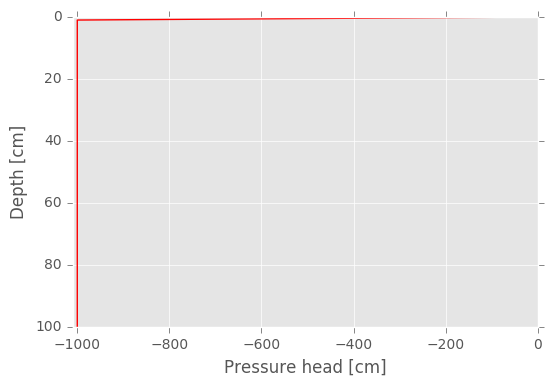

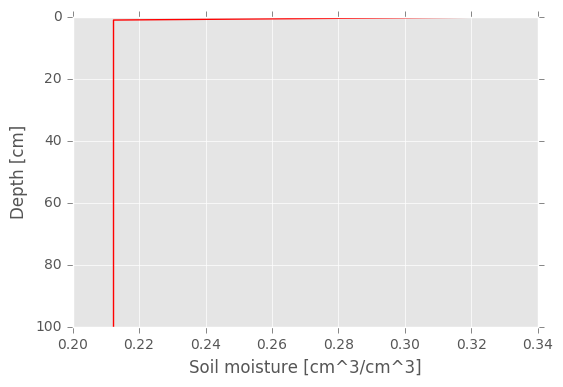

In [18]:
plt.figure(1); 
plt.plot(hinit,z,'r-');
plt.xlabel('Pressure head [cm]');
plt.ylabel('Depth [cm]');
plt.xlim( -1010, 0)
plt.gca().invert_yaxis()

plt.figure(2); 
plt.plot(thetainit,z,'r');
plt.xlabel('Soil moisture [cm^3/cm^3]');
plt.ylabel('Depth [cm]'); 
# Define the container for an iteration counter
plt.gca().invert_yaxis()


 # Define the container for an iteration counter
iterations = np.zeros([nt-1,1]);

# Initialize the Picard iteration solver
for i in range(1, nt): 
    hnp1m =  H[:,i-1]  
    #Enter the iteration step
    thetan = THETA[:,i-1]   
    #Define a dummy stopping variable
    stop_flag = 0
    # Define an iteration counter
    niter = 0
    while(stop_flag==0): # Get C,K,theta
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi); 
        #  Compute the individual elements of the A matrix for LHS
        C = np.diag(cnp1m); 
        kbarplus = (1/2.)*MPlus.dot(knp1m);
        Kbarplus = np.diag(kbarplus); 
        kbarminus = (1/2.)*MMinus.dot(knp1m);
        Kbarminus = np.diag(kbarminus); 
        A = (1/dt)*C - 1/((dz)**2)*(Kbarplus.dot(DeltaPlus) - Kbarminus.dot(DeltaMinus)); 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
            (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1
        deltam = np.linalg.pinv(A).dot(R_MPFD); 
        # Increment iteration counter and display number of iterations
        niter = niter + 1;

        if max(abs(deltam[1:(nz-1)]))<stop_tol:
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam # Force boundary conditions       
            hnp1mp1[0] = htop;
            if BottomBoundCon==0:
                hnp1mp1[nz-1] = hbottom;
            elif (BottomBoundCon==1):
                hnp1mp1[nz-1] = hnp1m[nz-2];
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            thetanp1mp1 = thetanp1m;
        else:
            hnp1mp1 = hnp1m + deltam;
            hnp1m = hnp1mp1; # Force boundary conditions
            hnp1m[0] = htop;

            if BottomBoundCon==0:
                hnp1m[nz-1] = hbottom;
            elif BottomBoundCon==1:
                hnp1m[nz-1] = hnp1m[nz-2];
    # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
    THETA[:,i] = thetanp1mp1; 
    H[:,i] = hnp1mp1;
    #     if (np.mod(i,10)==0):
    #         plt.figure(1, figsize= (6,5))
    #         plt.plot(hnp1mp1,z)
    #         plt.xlabel('Pressure head [cm]')
    #         plt.ylabel('Depth [cm]')
    #         plt.ylim(100, 0)
    #         plt.figure(2, figsize= (6,5))
    #         plt.plot(thetanp1mp1,z)
    #         plt.xlabel('Soil moisture [cm$^3/$cm$^3$]')
    #         plt.ylabel('Depth [cm]')
    #         plt.ylim(100, 0)
    #save number of iterations
    iterations[i-1] = niter;

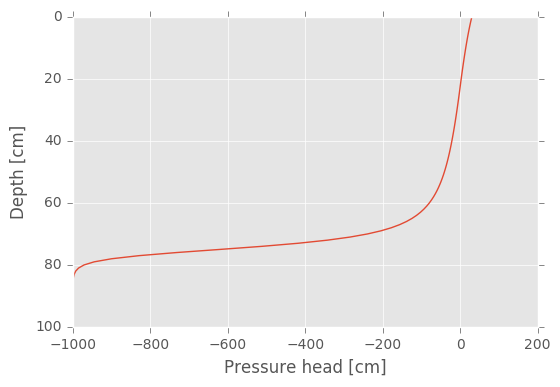

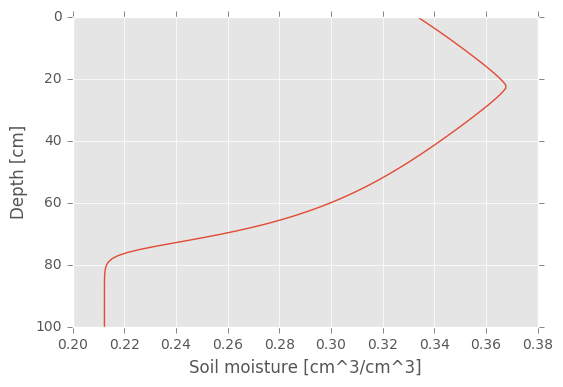

In [98]:
plt.figure(1); 
plt.plot(hnp1mp1,z);
plt.xlabel('Pressure head [cm]');
plt.ylabel('Depth [cm]');
plt.gca().invert_yaxis()
plt.figure(2); 
plt.plot(thetanp1mp1,z);
plt.xlabel('Soil moisture [cm^3/cm^3]');
plt.ylabel('Depth [cm]');
plt.gca().invert_yaxis()

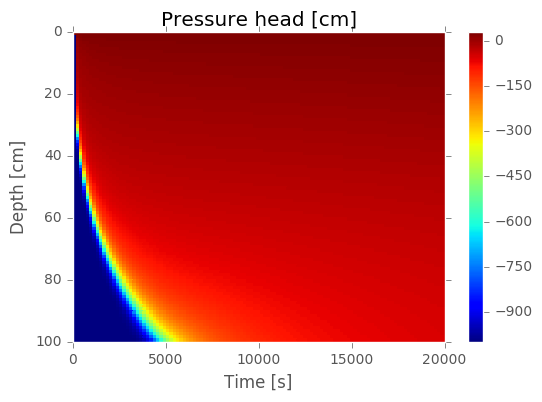

In [82]:
plt.figure(1); 
plt.pcolormesh(t, z, H)
plt.xlabel('Pressure head [cm]');
plt.ylabel('Depth [cm]');
plt.gca().invert_yaxis()
plt.xlabel('Time [s]');
plt.ylabel('Depth [cm]');
plt.xticks(np.arange(0, 20001, 5000))
plt.xlim([tmin, tmax]);
plt.colorbar();
plt.title('Pressure head [cm]');


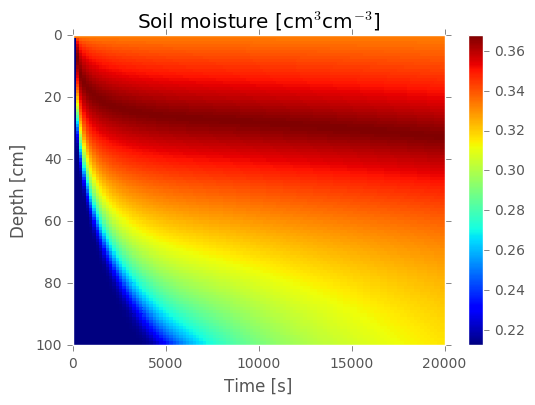

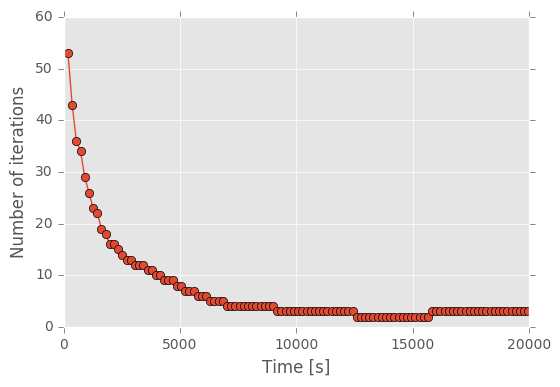

In [83]:
plt.figure(4); 
plt.pcolormesh(t, z, THETA)
plt.xlabel('Time [s]');
plt.ylabel('Depth [cm]');
plt.xlim([tmin, tmax]);
plt.ylim([zmin, zmax]);
plt.colorbar();
plt.gca().invert_yaxis()
plt.title('Soil moisture [cm$^3$cm$^{-3}$]');

plt.figure(5);
plt.plot(t[1:nt],iterations,'o-');
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations');

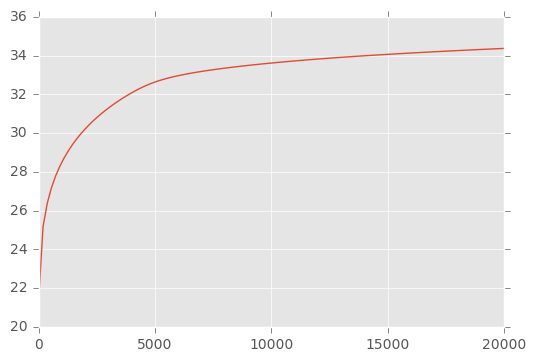

In [84]:
plt.plot(t,THETA.sum(0))